In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
class Linear_BBB(nn.Module):
    """
        Layer of our BNN.
    """
    def __init__(self, input_features, output_features, prior_var=1.):
        """
            Initialization of our layer : our prior is a normal distribution
            centered in 0 and of variance 20.
        """
        # initialize layers
        super().__init__()
        # set input and output dimensions
        self.input_features = input_features
        self.output_features = output_features

        # initialize mu and rho parameters for the weights of the layer
        self.w_mu = nn.Parameter(torch.zeros(output_features, input_features))
        self.w_rho = nn.Parameter(torch.zeros(output_features, input_features))

        #initialize mu and rho parameters for the layer's bias
        self.b_mu =  nn.Parameter(torch.zeros(output_features))
        self.b_rho = nn.Parameter(torch.zeros(output_features))

        #initialize weight samples (these will be calculated whenever the layer makes a prediction)
        self.w = None
        self.b = None

        # initialize prior distribution for all of the weights and biases
        self.prior = torch.distributions.Normal(0,prior_var)
    def look(self):
         # sample weights
        w_epsilon = Normal(0,1).sample(self.w_mu.shape)
        self.w = self.w_mu + torch.log(1+torch.exp(self.w_rho)) * w_epsilon

        # sample bias
        b_epsilon = Normal(0,1).sample(self.b_mu.shape)
        self.b = self.b_mu + torch.log(1+torch.exp(self.b_rho)) * b_epsilon

        return self.w, self.b
    def forward(self, input):
        """
          Optimization process
        """
        # sample weights
        w_epsilon = Normal(0,1).sample(self.w_mu.shape)
        self.w = self.w_mu + torch.log(1+torch.exp(self.w_rho)) * w_epsilon

        # sample bias
        b_epsilon = Normal(0,1).sample(self.b_mu.shape)
        self.b = self.b_mu + torch.log(1+torch.exp(self.b_rho)) * b_epsilon

        # record log prior by evaluating log pdf of prior at sampled weight and bias
        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)

        # record log variational posterior by evaluating log pdf of normal distribution defined by parameters with respect at the sampled values
        self.w_post = Normal(self.w_mu.data, torch.log(1+torch.exp(self.w_rho)))
        self.b_post = Normal(self.b_mu.data, torch.log(1+torch.exp(self.b_rho)))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()

        return F.linear(input, self.w, self.b)

In [3]:
class MLP_BBB(nn.Module):
    def __init__(self, hidden_units, noise_tol=.1,  prior_var=1.):

        # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
        super().__init__()
        self.hidden = Linear_BBB(1,hidden_units, prior_var=prior_var)
        self.out = Linear_BBB(hidden_units, 1, prior_var=prior_var)
        self.noise_tol = noise_tol # we will use the noise tolerance to calculate our likelihood

    def forward(self, x):
        # again, this is equivalent to a standard multilayer perceptron
        x = torch.sigmoid(self.hidden(x))
        x = self.out(x)
        return x

    def log_prior(self):
        # calculate the log prior over all the layers
        return self.hidden.log_prior + self.out.log_prior

    def log_post(self):
        # calculate the log posterior over all the layers
        return self.hidden.log_post + self.out.log_post
    def looks(self):
        return [self.hidden.look(),self.out.look()]
    def sample_elbo(self, input, target, samples):
        # we calculate the negative elbo, which will be our loss function
        #initialize tensors
        outputs = torch.zeros(samples, target.shape[0])
        log_priors = torch.zeros(samples)
        log_posts = torch.zeros(samples)
        log_likes = torch.zeros(samples)
        # make predictions and calculate prior, posterior, and likelihood for a given number of samples
        for i in range(samples):
            outputs[i] = self(input).reshape(-1) # make predictions
            log_priors[i] = self.log_prior() # get log prior
            log_posts[i] = self.log_post() # get log variational posterior
            log_likes[i] = Normal(outputs[i], self.noise_tol).log_prob(target.reshape(-1)).sum() # calculate the log likelihood
        # calculate monte carlo estimate of prior posterior and likelihood
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        # calculate the negative elbo (which is our loss function)
        loss = log_post - log_prior - log_like
        return loss
    def sample_model(self):

        return 1

In [4]:
def toy_function(x):
    return -x**4 + 3*x**2 + 1

# toy dataset we can start with
x = torch.tensor([-2,-1.8,0.0,1]).reshape(-1,1)
y = toy_function(x)

In [5]:
net=MLP_BBB(32,prior_var=10)
oprimizer=optim.Adam(net.parameters(),lr=.1)
epochs=3000
for epoch in range(epochs):
    oprimizer.zero_grad()
    loss=net.sample_elbo(x,y,1)
    loss.backward()
    oprimizer.step()
    if epoch % 10 == 0:
        print('epoch: {}/{}'.format(epoch+1,epochs))
        print('Loss:', loss.item())
print('Finished Training')

epoch: 1/3000
Loss: 1094.0050048828125
epoch: 11/3000
Loss: 2096.30029296875
epoch: 21/3000
Loss: 1461.4339599609375
epoch: 31/3000
Loss: 1800.7562255859375
epoch: 41/3000
Loss: 594.652587890625
epoch: 51/3000
Loss: 674.568603515625
epoch: 61/3000
Loss: 538.6182861328125
epoch: 71/3000
Loss: 876.4312744140625
epoch: 81/3000
Loss: 571.5071411132812
epoch: 91/3000
Loss: 582.1259155273438
epoch: 101/3000
Loss: 1210.2890625
epoch: 111/3000
Loss: 511.13043212890625
epoch: 121/3000
Loss: 590.0751953125
epoch: 131/3000
Loss: 639.2810668945312
epoch: 141/3000
Loss: 531.6744384765625
epoch: 151/3000
Loss: 741.4735107421875
epoch: 161/3000
Loss: 588.1654052734375
epoch: 171/3000
Loss: 674.2784423828125
epoch: 181/3000
Loss: 502.14617919921875
epoch: 191/3000
Loss: 553.4554443359375
epoch: 201/3000
Loss: 505.3985900878906
epoch: 211/3000
Loss: 657.3463134765625
epoch: 221/3000
Loss: 824.2254638671875
epoch: 231/3000
Loss: 668.7772216796875
epoch: 241/3000
Loss: 516.5711669921875
epoch: 251/3000
L

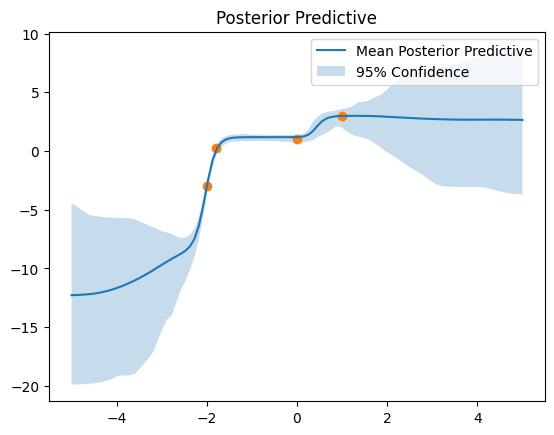

In [6]:
# samples is the number of "predictions" we make for 1 x-value.
samples = 100
x_tmp = torch.linspace(-5,5,100).reshape(-1,1)
y_samp = np.zeros((samples,100))
for s in range(samples):
    y_tmp = net(x_tmp).detach().numpy()
    y_samp[s] = y_tmp.reshape(-1)
plt.plot(x_tmp.numpy(), np.mean(y_samp, axis = 0), label='Mean Posterior Predictive')
plt.fill_between(x_tmp.numpy().reshape(-1), np.percentile(y_samp, 2.5, axis = 0), np.percentile(y_samp, 97.5, axis = 0), alpha = 0.25, label='95% Confidence')
plt.legend()
plt.scatter(x, toy_function(x))
plt.title('Posterior Predictive')

plt.show()

In [7]:
x_tmp.shape

torch.Size([100, 1])

In [8]:
for param_tensor in net.state_dict(): # 字典的遍历默认是遍历 key，所以param_tensor实际上是键值
    print(param_tensor,'\t',net.state_dict()[param_tensor].size())


hidden.w_mu 	 torch.Size([32, 1])
hidden.w_rho 	 torch.Size([32, 1])
hidden.b_mu 	 torch.Size([32])
hidden.b_rho 	 torch.Size([32])
out.w_mu 	 torch.Size([1, 32])
out.w_rho 	 torch.Size([1, 32])
out.b_mu 	 torch.Size([1])
out.b_rho 	 torch.Size([1])


In [10]:
net.looks()

[(tensor([[ 4.8168],
          [-2.2421],
          [ 1.2990],
          [-4.9487],
          [ 4.7062],
          [ 3.1305],
          [ 3.7335],
          [ 1.8265],
          [ 3.1776],
          [ 1.0642],
          [ 0.8867],
          [-1.5903],
          [ 4.2174],
          [-0.8699],
          [ 1.9492],
          [ 4.0269],
          [ 0.9816],
          [-2.4562],
          [ 2.6244],
          [ 2.2555],
          [-3.6767],
          [ 3.2212],
          [ 0.6441],
          [ 0.6688],
          [ 0.6002],
          [ 2.3441],
          [ 7.0971],
          [ 1.4540],
          [ 1.0415],
          [ 2.4636],
          [11.7806],
          [-8.6959]], grad_fn=<AddBackward0>),
  tensor([ -8.8652,  -4.7405, -11.0636, -15.3396,  -7.0507,  -7.6710, -12.4108,
           -9.0630,  -8.2147,  -9.4731, -12.4640, -13.3928,  -9.8216, -11.1059,
            2.2471,  -6.7621,  -7.6663,  -4.9661,  -7.6961, -10.8082, -10.9535,
          -12.0915,  -5.6336,  -1.4563,  -8.3181, -10.1124, -1